# Explore Obesity Data 02
Forming groups or buckets with counties of similiar obesity data.  
**Author:** Matthias Titze s0563413

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**File Pathes**

In [2]:
# File pathes for quick adjustment if places or directories change.
path_input = '00_data_input'
path_temp = '01_data_temp'
path_inter = '02_data_intermediate'
path_output = '03_data_output'
path_atlas = os.path.join(path_input, 'food_atlas.xls')
path_obesity = os.path.join(path_inter, 'obesity_refined_data.csv')

**Read Data Sources**

In [13]:
df_obesity = pd.read_csv(path_obesity)
df_obesity[:3]

,county_fips,county,state,PCT_obese_adults_2008,PCT_obese_adults_2013,PCT_obese_adults_average,PCT_obese_adults_change
0,1001,Autauga,AL,31.5,34.1,32.8,2.6
1,1003,Baldwin,AL,26.2,27.4,26.8,1.2
2,1005,Barbour,AL,37.6,44.4,41.0,6.8


### Putting Counties into Obesity Groups
We want to throw all counties with a similiar obesity value into one group(e.g. all counties with obesity 22-24%).  
This is the analytic expansion of the obesity historgrams which do not yet carry the associated county information.  
Considering the deviation of the change in obesity from 2008 to 2013 (fluctuation of the data over the years) buckets of range 2% seem adequate.  
This means we form groups starting at 10% ... 12%-14%, 14%-26% ... up to 50%. Each county will land in one of these groups.

In [4]:
def plot_distribution(title, series, lower_limit, upper_limit, bin_precision, y_limit, color):
    bins = np.linspace(lower_limit, upper_limit, ((upper_limit - lower_limit) / bin_precision) + 1)
    sns.set_color_codes()
    sns.set(font_scale=1.4)
    plt.subplots(figsize=(20,8))
    plt.title(title) 
    plt.xlim(lower_limit, upper_limit)
    plt.ylim(0, y_limit)
    sns.distplot(series.dropna(), bins=bins, color=color, kde=False) 

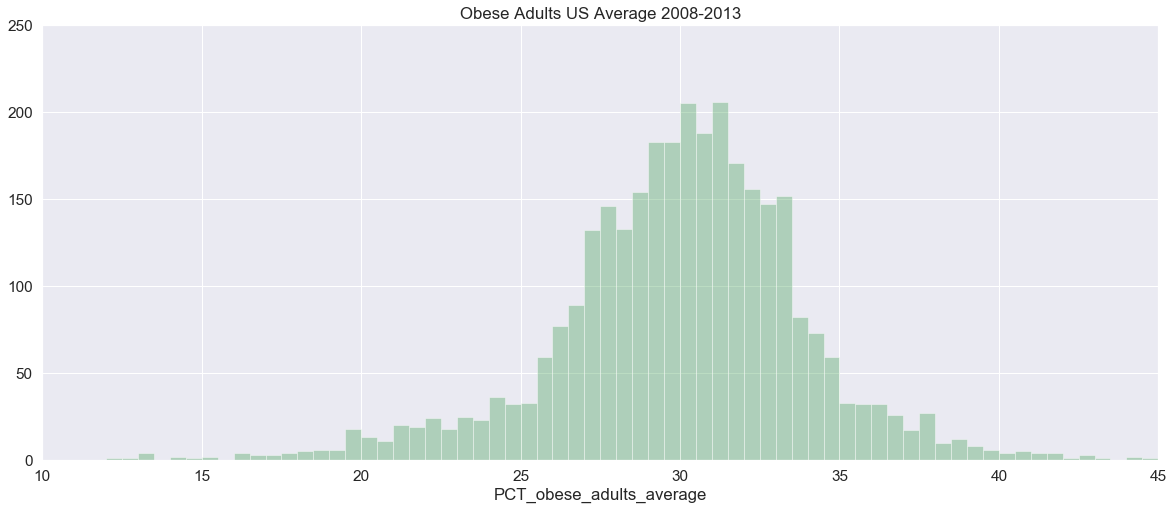

In [6]:
plot_distribution('Obese Adults US Average 2008-2013', df_obesity['PCT_obese_adults_average'], 10, 45, 0.5, 250, 'g')

**Test Bucket**

In [14]:
# Test example of group (bucket) 12-14% adult obeseity rate.
df_obesity[(df_obesity['PCT_obese_adults_average'] >= 12) & (df_obesity['PCT_obese_adults_average'] < 14)]

,county_fips,county,state,PCT_obese_adults_2008,PCT_obese_adults_2013,PCT_obese_adults_average,PCT_obese_adults_change
250,8013,Boulder,CO,13.2,13.4,13.30,0.2
263,8037,Eagle,CO,12.9,11.8,12.35,-1.1
298,8107,Routt,CO,11.7,14.3,13.00,2.6
303,8117,Summit,CO,13.0,13.1,13.05,0.1
1821,35049,Santa Fe,NM,12.9,13.7,13.30,0.8
3139,56039,Teton,WY,13.2,12.7,12.95,-0.5


**Create** obesity group buckets.

In [16]:
# List of the fips in each bucket plus some leading description values.
obesity_buckets = []
# Values defining the obesity ranges thrown into each bucket.
lower_limit = 10
upper_limit = 50
bucket_range_step = 2
bucket_start = lower_limit
bucket_end = bucket_start + bucket_range_step

for i in range(lower_limit, upper_limit, bucket_range_step):
    # Get a sub-dataframe with all the counties whose obesity rates fit into the bucket range.
    df_bucket = df_obesity[(df_obesity['PCT_obese_adults_average'] >= bucket_start) \
                           & (df_obesity['PCT_obese_adults_average'] < bucket_end)]
    # Convert the county fips code column of this sub-dataframe into a list.
    bucket_fips_list = df_bucket['county_fips'].tolist()
    bucket_fips_str = ''
    for fips in bucket_fips_list:
        bucket_fips_str = bucket_fips_str + ', ' + str(fips)
    bucket_fips_str = bucket_fips_str[2:]
    # Create a label describing the obesity rate range of the bucket.
    bucket_description = '%[{}-{}['.format(bucket_start, bucket_end)
    # Package all bucket information into a tupel which we then add to our list of fips-code buckets.
    obesity_buckets.append((bucket_description, bucket_fips_str))
    # Move on to the next bucket by adjusting the obesity range values.
    bucket_start = bucket_end
    bucket_end = bucket_end + bucket_range_step

# Just have a quick look at the format and content of the resulting buckets (easier debugging).
print('Bucket examples (Just a sample for debugging - there are way more fips in each bucket!):')
print('{} : {}'.format(obesity_buckets[0][0], obesity_buckets[0][1]))
print('{} : {}'.format(obesity_buckets[1][0], obesity_buckets[1][1]))
print('{} : {}'.format(obesity_buckets[2][0], obesity_buckets[2][1]))
print('{} : {}'.format(obesity_buckets[3][0], obesity_buckets[3][1]))

Bucket examples (Just a sample for debugging - there are way more fips in each bucket!):
%[10-12[ : 
%[12-14[ : 8013, 8037, 8107, 8117, 35049, 56039
%[14-16[ : 8051, 8067, 8097, 36061, 49043
%[16-18[ : 6041, 6075, 8007, 8015, 8031, 8035, 8045, 8049, 8065, 8069, 8113, 16013, 30031, 35055


**Write** obesity group fips list **to file** for later use in other case.  
This requires tricky manual .csv creation and is a bit hacky. All the issues arise from not having created a dataframe in the first place.

In [17]:
# Try to create some .csv alike file syntax. This has some issues we need to solve later.
path_obesity_buckets_fips = os.path.join(path_inter, 'obesity_buckets_fips.csv')
with open(path_obesity_buckets_fips, "w") as f:
    f.write('bucket_index; bucket_range; bucket_size; county_fips\n')
    for i in range(len(obesity_buckets)):
        f.write('{};{};{};{}\n'.format(i, obesity_buckets[i][0], len(obesity_buckets[i][1]), obesity_buckets[i][1]))

def read_obesity_buckets_fips():
    '''Reads in the obesity buckets fips list and converts the content into a dataframe.'''
    with open(path_obesity_buckets_fips) as f:
        # Read the first file line as colum header.
        rows = f.readlines()
        columns = rows[0].split('; ')
        columns[3] = columns[3][:-1]
        df = pd.DataFrame([], columns=columns)
        
        # Now read in the other lines as data values.
        for i in range(1, len(rows)):
            values = rows[i].split(';')
            dic = {columns[1]:values[1], columns[2]:int(values[2]), columns[3]:values[3][:-1]}
            df_add = pd.DataFrame(pd.Series(dic)).transpose()
            df = pd.concat([df, df_add])
        
        # Drop the index column as it is implicitly given.
        df.drop(['bucket_index'], axis=1, inplace=True)
        return df

# Read in a dataframe from the problematic .csv file and convert manually to dataframe.
df_obesity_bucket_fips = read_obesity_buckets_fips()
# Use pandas standard function to write a clean .csv file directly from the dataframe.
df_obesity_bucket_fips.to_csv(path_obesity_buckets_fips, index=False)
# Read in the final clean dataframe from the correct .csv file.
df_obesity_bucket_fips = pd.read_csv(path_obesity_buckets_fips)
df_obesity_bucket_fips

,bucket_range,bucket_size,county_fips
0,%[10-12[,0,NaN
1,%[12-14[,36,"8013, 8037, 8107, 8117, 35049, 56039"
2,%[14-16[,30,"8051, 8067, 8097, 36061, 49043"
3,%[16-18[,85,"6041, 6075, 8007, 8015, 8031, 8035, 8045, 8049..."
4,%[18-20[,219,"6001, 6059, 6083, 6085, 6087, 8014, 8019, 8027..."
5,%[20-22[,414,"6017, 6037, 6045, 6051, 6057, 6061, 6073, 6081..."
6,%[22-24[,604,"4005, 4019, 4023, 4025, 6009, 6027, 6049, 6053..."
7,%[24-26[,1095,"4003, 4013, 6003, 6005, 6007, 6011, 6013, 6023..."
8,%[26-28[,3087,"1003, 2020, 2090, 2100, 2110, 4007, 6015, 6019..."
9,%[28-30[,4546,"1029, 1081, 1095, 1117, 1133, 2068, 2122, 2150..."


### Analysing County Obesity Groups
We want to calculate some additional data to have a closer look at each obesity group we formed earlier.  
Therefore we create a new dataframe with mean, meadian and standard deviation values for the obesity rates of each group (bucket).

In [18]:
def get_obesity_values_for_fips_list(fips_list, column='PCT_obese_adults_average'):
    '''Gets a list of obesity values - one value for each code in the fips list.'''
    values_list = []
    
    for fips in fips_list:
        # Get the obesity value sub-dataframe for the county fips and extract the value to add to the list.
        obesity_value = df_obesity[df_obesity['county_fips']==int(fips)][column].iloc[0]
        values_list.append(obesity_value)
        
    return values_list

In [19]:
# We want to work on these columns of the refined obesity data.
columns = ['obesity_bucket','n_fips','PCT_obesity_mean','PCT_obesity_median','PCT_obesity_stddev']
# Set up the layout of the new dataframe using the columns above.
df_obesity_bucket_data = pd.DataFrame([],columns=columns)
precision = 3

# Now analyse each obesity group (iterate through dataframe rows).
# Remenber, the fips (county) buckets group together counties whith a similiar obesity rate.
for i in range(len(df_obesity_bucket_fips.index)):
    
    # Extract the row's data fields.
    bucket_range = df_obesity_bucket_fips['bucket_range'].iloc[i]
    n_fips = df_obesity_bucket_fips['bucket_size'].iloc[i]
    fips_list_str = df_obesity_bucket_fips['county_fips'].iloc[i]
    
    # Calculate some standard statistical values for each obesity bucket.
    obesity_mean = 0
    obesity_median = 0
    obesity_stddev = 0
    
    if (n_fips != 0):
        fips_list = fips_list_str.split(', ')
        obesity_values = get_obesity_values_for_fips_list(fips_list)
        obesity_mean = round(np.nanmean(obesity_values), precision)
        obesity_median = round(np.nanmedian(obesity_values), precision)
        obesity_stddev = round(np.nanstd(obesity_values), precision)

    # Add a data row for the fips bucket to the new dataframe.
    row = {'obesity_bucket':bucket_range,'n_fips':n_fips, \
           'PCT_obesity_mean':obesity_mean,'PCT_obesity_median':obesity_median,'PCT_obesity_stddev':obesity_stddev}
    df_obesity_bucket_data = df_obesity_bucket_data.append(row, ignore_index=True)
    
df_obesity_bucket_data

,obesity_bucket,n_fips,PCT_obesity_mean,PCT_obesity_median,PCT_obesity_stddev
0,%[10-12[,0,0,0,0
1,%[12-14[,36,12.992,13.025,0.318
2,%[14-16[,30,14.8,14.85,0.507
3,%[16-18[,85,16.979,17.025,0.645
4,%[18-20[,219,19.249,19.5,0.568
5,%[20-22[,414,21.117,21.2,0.559
6,%[22-24[,604,22.988,23.05,0.582
7,%[24-26[,1095,25.077,25.15,0.6
8,%[26-28[,3087,27.129,27.2,0.552
9,%[28-30[,4546,29.051,29.1,0.569


**Write** obesity group data **to file** for later use in other case.

In [20]:
path_obesity_buckets_data = os.path.join(path_inter, 'obesity_buckets_data.csv')
df_obesity_bucket_data.to_csv(os.path.join(path_obesity_buckets_data), index=False)